<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/uvipen/Tetris-deep-Q-learning-pytorch

In [1]:
import os
import cv2
import torch
import random
import shutil
import argparse
import numpy as np
from PIL import Image
import torch.nn as nn
from matplotlib import style
from collections import deque
from random import random, randint, sample
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
class Tetris:
    piece_colors = [
        (0, 0, 0),
        (255, 255, 0),
        (147, 88, 254),
        (54, 175, 144),
        (255, 0, 0),
        (102, 217, 238),
        (254, 151, 32),
        (0, 0, 255)
    ]

    pieces = [
        [[1, 1],
         [1, 1]],

        [[0, 2, 0],
         [2, 2, 2]],

        [[0, 3, 3],
         [3, 3, 0]],

        [[4, 4, 0],
         [0, 4, 4]],

        [[5, 5, 5, 5]],

        [[0, 0, 6],
         [6, 6, 6]],

        [[7, 0, 0],
         [7, 7, 7]]
    ]

    def __init__(self, height=20, width=10, block_size=20):
        self.height = height
        self.width = width
        self.block_size = block_size
        self.extra_board = np.ones((self.height * self.block_size, self.width * int(self.block_size / 2), 3),
                                   dtype=np.uint8) * np.array([204, 204, 255], dtype=np.uint8)
        self.text_color = (200, 20, 220)
        self.reset()

    def reset(self):
        self.board = [[0] * self.width for _ in range(self.height)]
        self.score = 0
        self.tetrominoes = 0
        self.cleared_lines = 0
        self.bag = list(range(len(self.pieces)))
        shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2, "y": 0}
        self.gameover = False
        return self.get_state_properties(self.board)

    def rotate(self, piece):
        num_rows_orig = num_cols_new = len(piece)
        num_rows_new = len(piece[0])
        rotated_array = []

        for i in range(num_rows_new):
            new_row = [0] * num_cols_new
            for j in range(num_cols_new):
                new_row[j] = piece[(num_rows_orig - 1) - j][i]
            rotated_array.append(new_row)
        return rotated_array

    def get_state_properties(self, board):
        lines_cleared, board = self.check_cleared_rows(board)
        holes = self.get_holes(board)
        bumpiness, height = self.get_bumpiness_and_height(board)

        return torch.FloatTensor([lines_cleared, holes, bumpiness, height])

    def get_holes(self, board):
        num_holes = 0
        for col in zip(*board):
            row = 0
            while row < self.height and col[row] == 0:
                row += 1
            num_holes += len([x for x in col[row + 1:] if x == 0])
        return num_holes

    def get_bumpiness_and_height(self, board):
        board = np.array(board)
        mask = board != 0
        invert_heights = np.where(mask.any(axis=0), np.argmax(mask, axis=0), self.height)
        heights = self.height - invert_heights
        total_height = np.sum(heights)
        currs = heights[:-1]
        nexts = heights[1:]
        diffs = np.abs(currs - nexts)
        total_bumpiness = np.sum(diffs)
        return total_bumpiness, total_height

    def get_next_states(self):
        states = {}
        piece_id = self.ind
        curr_piece = [row[:] for row in self.piece]
        if piece_id == 0:  # O piece
            num_rotations = 1
        elif piece_id == 2 or piece_id == 3 or piece_id == 4:
            num_rotations = 2
        else:
            num_rotations = 4

        for i in range(num_rotations):
            valid_xs = self.width - len(curr_piece[0])
            for x in range(valid_xs + 1):
                piece = [row[:] for row in curr_piece]
                pos = {"x": x, "y": 0}
                while not self.check_collision(piece, pos):
                    pos["y"] += 1
                self.truncate(piece, pos)
                board = self.store(piece, pos)
                states[(x, i)] = self.get_state_properties(board)
            curr_piece = self.rotate(curr_piece)
        return states

    def get_current_board_state(self):
        board = [x[:] for x in self.board]
        for y in range(len(self.piece)):
            for x in range(len(self.piece[y])):
                board[y + self.current_pos["y"]][x + self.current_pos["x"]] = self.piece[y][x]
        return board

    def new_piece(self):
        if not len(self.bag):
            self.bag = list(range(len(self.pieces)))
            shuffle(self.bag)
        self.ind = self.bag.pop()
        self.piece = [row[:] for row in self.pieces[self.ind]]
        self.current_pos = {"x": self.width // 2 - len(self.piece[0]) // 2,
                            "y": 0
                            }
        if self.check_collision(self.piece, self.current_pos):
            self.gameover = True

    def check_collision(self, piece, pos):
        future_y = pos["y"] + 1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if future_y + y > self.height - 1 or self.board[future_y + y][pos["x"] + x] and piece[y][x]:
                    return True
        return False

    def truncate(self, piece, pos):
        gameover = False
        last_collision_row = -1
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x]:
                    if y > last_collision_row:
                        last_collision_row = y

        if pos["y"] - (len(piece) - last_collision_row) < 0 and last_collision_row > -1:
            while last_collision_row >= 0 and len(piece) > 1:
                gameover = True
                last_collision_row = -1
                del piece[0]
                for y in range(len(piece)):
                    for x in range(len(piece[y])):
                        if self.board[pos["y"] + y][pos["x"] + x] and piece[y][x] and y > last_collision_row:
                            last_collision_row = y
        return gameover

    def store(self, piece, pos):
        board = [x[:] for x in self.board]
        for y in range(len(piece)):
            for x in range(len(piece[y])):
                if piece[y][x] and not board[y + pos["y"]][x + pos["x"]]:
                    board[y + pos["y"]][x + pos["x"]] = piece[y][x]
        return board

    def check_cleared_rows(self, board):
        to_delete = []
        for i, row in enumerate(board[::-1]):
            if 0 not in row:
                to_delete.append(len(board) - 1 - i)
        if len(to_delete) > 0:
            board = self.remove_row(board, to_delete)
        return len(to_delete), board

    def remove_row(self, board, indices):
        for i in indices[::-1]:
            del board[i]
            board = [[0 for _ in range(self.width)]] + board
        return board

    def step(self, action, render=True, video=None):
        x, num_rotations = action
        self.current_pos = {"x": x, "y": 0}
        for _ in range(num_rotations):
            self.piece = self.rotate(self.piece)

        while not self.check_collision(self.piece, self.current_pos):
            self.current_pos["y"] += 1
            if render:
                self.render(video)

        overflow = self.truncate(self.piece, self.current_pos)
        if overflow:
            self.gameover = True

        self.board = self.store(self.piece, self.current_pos)

        lines_cleared, self.board = self.check_cleared_rows(self.board)
        score = 1 + (lines_cleared ** 2) * self.width
        self.score += score
        self.tetrominoes += 1
        self.cleared_lines += lines_cleared
        if not self.gameover:
            self.new_piece()
        if self.gameover:
            self.score -= 2

        return score, self.gameover

    def render(self, video=None):
        if not self.gameover:
            img = [self.piece_colors[p] for row in self.get_current_board_state() for p in row]
        else:
            img = [self.piece_colors[p] for row in self.board for p in row]
        img = np.array(img).reshape((self.height, self.width, 3)).astype(np.uint8)
        img = img[..., ::-1]
        img = Image.fromarray(img, "RGB")

        img = img.resize((self.width * self.block_size, self.height * self.block_size))
        img = np.array(img)
        img[[i * self.block_size for i in range(self.height)], :, :] = 0
        img[:, [i * self.block_size for i in range(self.width)], :] = 0

        img = np.concatenate((img, self.extra_board), axis=1)


        cv2.putText(img, "Score:", (self.width * self.block_size + int(self.block_size / 2), self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.score),
                    (self.width * self.block_size + int(self.block_size / 2), 2 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        cv2.putText(img, "Pieces:", (self.width * self.block_size + int(self.block_size / 2), 4 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.tetrominoes),
                    (self.width * self.block_size + int(self.block_size / 2), 5 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        cv2.putText(img, "Lines:", (self.width * self.block_size + int(self.block_size / 2), 7 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)
        cv2.putText(img, str(self.cleared_lines),
                    (self.width * self.block_size + int(self.block_size / 2), 8 * self.block_size),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.0, color=self.text_color)

        if video:
            video.write(img)

        plt.figure(figsize=(10, 10));
        plt.axis('off')
        plt.grid(b=None)
        plt.imshow(img,interpolation='none')
        plt.show()

In [30]:
env = Tetris(width=10, height=20, block_size=30)
state = env.reset()

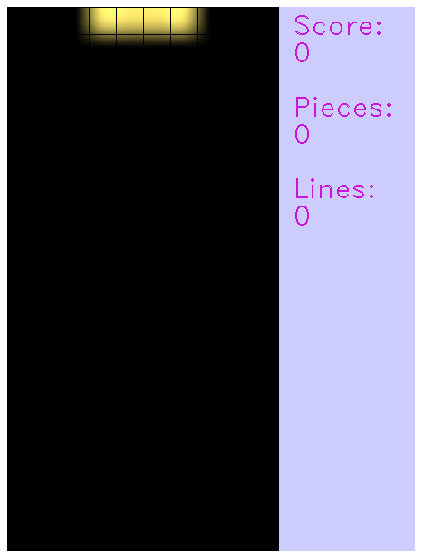

In [31]:
env.render()

In [32]:
state

tensor([0., 0., 0., 0.])

In [ ]:
state = env.step((4,2))

In [12]:
next_steps = env.get_next_states()
next_actions, next_states = zip(*next_steps.items())

In [ ]:
next_actions

In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()

        self.conv1 = nn.Sequential(nn.Linear(4, 64),  nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Linear(64, 1))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        return x

In [10]:
def train():

    width = 10
    height = 20
    block_size = 30
    batch_size = 512
    lr = 1e-3
    replay_memory_size = 30000    
    num_epochs = 2000
    initial_epsilon =  1
    final_epsilon = 1e-3
    num_decay_epochs = 2000
    gamma = 0.99

    env = Tetris(width=width, height=height, block_size=block_size)
    model = DeepQNetwork()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    state = env.reset().cuda()
    
    model.cuda()

    replay_memory = deque(maxlen=replay_memory_size)
    epoch = 0

    while epoch < num_epochs:

        next_steps = env.get_next_states()
        
                
        next_actions, next_states = zip(*next_steps.items())
        
        next_states = torch.stack(next_states).cuda()
                
        model.eval()
        
        with torch.no_grad():
            predictions = model(next_states)[:, 0]

        model.train()

        epsilon = final_epsilon + (max(num_decay_epochs - epoch, 0) * (initial_epsilon - final_epsilon) / num_decay_epochs)

        if random() <= epsilon:
            index = randint(0, len(next_steps) - 1)
        else:
            index = torch.argmax(predictions).item()

        next_state = next_states[index, :].cuda()
        action = next_actions[index]

        reward, done = env.step(action, render=False)

        replay_memory.append([state, reward, next_state, done])

        if done:
            final_score = env.score
            final_tetrominoes = env.tetrominoes
            final_cleared_lines = env.cleared_lines
            state = env.reset().cuda()

        else:
            state = next_state
            continue
        
        if len(replay_memory) < replay_memory_size / 10:
            continue
        
        epoch += 1

        batch = sample(replay_memory, min(len(replay_memory), batch_size))
        state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
        state_batch = torch.stack(tuple(state for state in state_batch))
        reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None])
        next_state_batch = torch.stack(tuple(state for state in next_state_batch))

        
        state_batch = state_batch.cuda()
        reward_batch = reward_batch.cuda()
        next_state_batch = next_state_batch.cuda()

        q_values = model(state_batch)

        model.eval()

        with torch.no_grad():
            next_prediction_batch = model(next_state_batch)

        model.train()

        y_batch = torch.cat(tuple(reward if done else reward + gamma * prediction for reward, done, prediction in zip(reward_batch, done_batch, next_prediction_batch)))[:, None]

        optimizer.zero_grad()
        loss = criterion(q_values, y_batch)
        loss.backward()
        optimizer.step()

        print("Epoch: ", epoch, "  Score: ", final_score)
        
    return model

In [11]:
model = train()

Epoch:  1   Score:  17
Epoch:  2   Score:  11
Epoch:  3   Score:  21
Epoch:  4   Score:  16
Epoch:  5   Score:  18
Epoch:  6   Score:  20
Epoch:  7   Score:  17
Epoch:  8   Score:  18
Epoch:  9   Score:  14
Epoch:  10   Score:  19
Epoch:  11   Score:  17
Epoch:  12   Score:  18
Epoch:  13   Score:  17
Epoch:  14   Score:  12
Epoch:  15   Score:  19
Epoch:  16   Score:  14
Epoch:  17   Score:  9
Epoch:  18   Score:  15
Epoch:  19   Score:  17
Epoch:  20   Score:  14
Epoch:  21   Score:  19
Epoch:  22   Score:  17
Epoch:  23   Score:  10
Epoch:  24   Score:  12
Epoch:  25   Score:  17
Epoch:  26   Score:  17
Epoch:  27   Score:  14
Epoch:  28   Score:  18
Epoch:  29   Score:  18
Epoch:  30   Score:  19
Epoch:  31   Score:  18
Epoch:  32   Score:  16
Epoch:  33   Score:  17
Epoch:  34   Score:  13
Epoch:  35   Score:  16
Epoch:  36   Score:  14
Epoch:  37   Score:  18
Epoch:  38   Score:  11
Epoch:  39   Score:  13
Epoch:  40   Score:  13
Epoch:  41   Score:  18
Epoch:  42   Score:  16
Ep

In [ ]:
def test():

    width = 10
    height = 20 
    block_size = 30 

    model.eval()
    env = Tetris(width=width, height=height, block_size=block_size)
    env.reset()
    model.cuda()

    while True:
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = torch.stack(next_states).cuda()
        predictions = model(next_states)[:, 0]
        index = torch.argmax(predictions).item()
        action = next_actions[index]
        done = env.step(action, render=True)[1]

In [ ]:
test()

In [ ]:
test()